

# Leaf Segmentation with <img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="200">

Trains a detectron2 model on Superfund leaf dataset.



# Setup

### Install requirements

In [1]:
%%capture

# requirements
!pip install pyyaml==5.1
!pip install opencv-python
!pip install matplotlib
!pip install openpyxl
!pip install funcy

# cocosplit requirements
!pip install sklearn funcy argparse scikit-multilearn

### Import Detectron2 and other Python Libraries

In [8]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

torch:  2.0 ; cuda:  cu117


# Prepare the Data

### Split dataset into train and test sets for k-fold cross validation

To make better use our small dataset (~176 images), we use k-fold cross validation.

First, we add some variables to specify where output from this training run should be stored, including the split k-fold test/train annotations and final model weights.  Set `today` to today's date and set `suffix` to specify how you'd like your output folder named (defaults to `kfold_train`).

In [3]:
today = "5000_iters_batchsize_4"

suffix = "kfold_train"

output_folder = '/home/jovyan/work/mask_rcnn/' + today + '_' + suffix
annotation_file = '/home/jovyan/work/data/2024-03-14_leaves_rotated.json'
data_folder = '/home/jovyan/work/data/2024-03-14_leaves'
# os.makedirs(output_folder, exist_ok=True)

Next set the number of folds for k-fold cross validation (defaults to k=5, which is pretty standard).

In [4]:
# number of folds for k-fold cross validation
k = 5

Next we run the `cocosplit_kfold` script to split the images into k folds and get the training and test sets for each iteration of k-fold cross validation. You can add the `-p` flag if you'd like to see the train/test indicies for each k-fold iteration to verify this is working as expected.

In [5]:
# shuffle and randomly split into k folds
run = f"python /home/jovyan/work/mask_rcnn/cocosplit_kfold.py\
         -k {k}\
         {annotation_file}\
         {output_folder}"

!{run}

Filtered out 36 images missing manual area calculations.
Final dataset size: 176 images

Fold 0
Training set size: 140 
Test set size: 36

Fold 1
Training set size: 141 
Test set size: 35

Fold 2
Training set size: 141 
Test set size: 35

Fold 3
Training set size: 141 
Test set size: 35

Fold 4
Training set size: 141 
Test set size: 35


Now, in the output folder, you should see JSON files containing the annotations for the training & test set for each iteration of k-fold cross validation.  For example `train_0.json` and `test_0.json` respectively contain the training and test annotations for the first training iteration.

### Register the dataset with Detectron2

Register the leaf dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [10]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

def maybe_unregister(name):
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
    if name in MetadataCatalog.list():
        MetadataCatalog.remove(name)

for fold in range(0, k):
    # Define dataset names
    train_dataset_name = f"train_{fold}"
    val_dataset_name = f"val_{fold}"

    # Unregister if they already exist
    maybe_unregister(train_dataset_name)
    maybe_unregister(val_dataset_name)

    # Paths to your JSON and image data
    train_json_path = f"{output_folder}/train_{fold}.json"
    val_json_path = f"{output_folder}/test_{fold}.json"
    image_root_path = f"{data_folder}"

    # Register the datasets again
    register_coco_instances(train_dataset_name, {}, train_json_path, image_root_path)
    register_coco_instances(val_dataset_name, {}, val_json_path, image_root_path)


In [ ]:
def get_leaf_only_dataset(json_path, image_dir, dataset_name):
    """Loads COCO dataset but keeps only the 'leaf' class annotations."""
    
    dataset_dicts = load_coco_json(json_path, image_dir, dataset_name)

    # Update this if "leaf" is not class index 0
    leaf_class_index = 0  # Set this based on your dataset

    filtered_dataset = []
    for image_dict in dataset_dicts:
        # Keep only annotations that belong to the "leaf" class
        leaf_annotations = [ann for ann in image_dict["annotations"] if ann["category_id"] == leaf_class_index]
        
        if leaf_annotations:  # Only keep images with at least one leaf
            image_dict["annotations"] = leaf_annotations
            filtered_dataset.append(image_dict)

    return filtered_dataset

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [11]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt

# Function to resize masks to match image dimensions
def resize_mask(mask, target_height, target_width):
    mask = mask.astype(np.uint8)  # Convert mask to uint8
    return cv2.resize(mask, (target_width, target_height))


def visualize_ground_truth(image, gt_masks, save_path=None):   

    v = Visualizer(image[:, :, ::-1],
        metadata=leaf_metadata, 
        scale=0.5
        # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    
    out = v.overlay_instances(
        boxes=None,
        masks=gt_masks,
        assigned_colors=None, # Use default colors
        alpha=0.5, # Set alpha for the overlay
        labels=None # Remove labels by setting it to None
    )
    
    height, width, _ = image.shape
    scale_factor = 0.5
    scaled_height = int(height * scale_factor)
    scaled_width = int(width * scale_factor)

    plt.figure(figsize=(scaled_width / 100, scaled_height / 100)) 
    plt.imshow(out.get_image()[:, :, ::-1])
    
    if save_path:
        plt.axis('off')  # Hide axes
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100)  # Save the image with DPI = 100
        plt.close()

WARNING [03/18 22:17:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/18 22:17:11 d2.data.datasets.coco]: Loaded 140 images in COCO format from /home/jovyan/work/mask_rcnn/5000_iters_batchsize_4_kfold_train/train_0.json
Metadata(name='train_0', json_file='/home/jovyan/work/mask_rcnn/5000_iters_batchsize_4_kfold_train/train_0.json', image_root='/home/jovyan/work/data/2024-03-14_leaves', evaluator_type='coco', thing_classes=['leaf', 'qr', 'red-square'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})
/home/jovyan/work/data/2024-03-14_leaves/IMG_5793.JPG


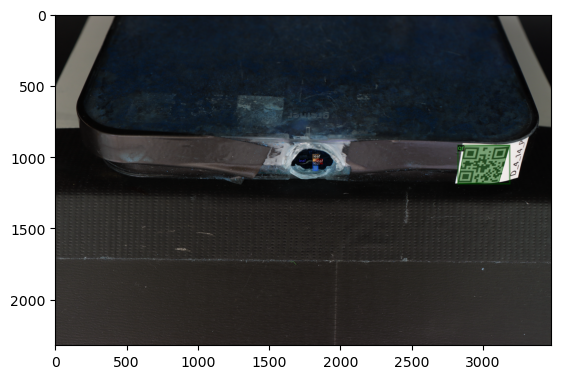

/home/jovyan/work/data/2024-03-14_leaves/IMG_5953.JPG


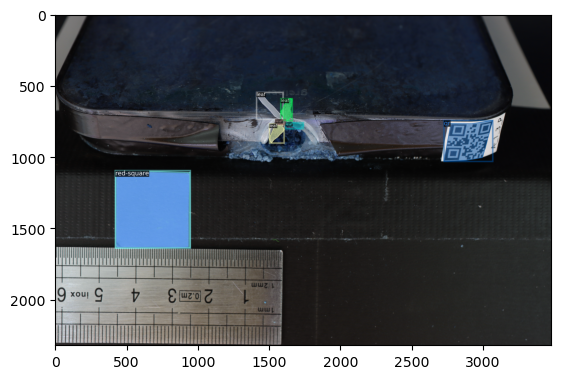

/home/jovyan/work/data/2024-03-14_leaves/IMG_5937.JPG


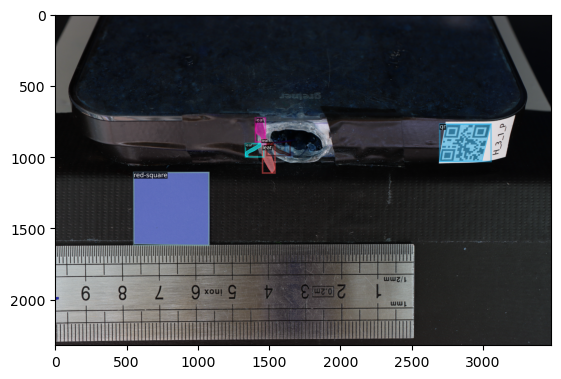

In [6]:
# import os
# os.chdir('../work/data/2024-03-14_leaves')

leaf_metadata = MetadataCatalog.get("train_0")
dataset_dicts = DatasetCatalog.get("train_0")

print(leaf_metadata)

for d in dataset_dicts:
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=leaf_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


# Time to Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the leaf dataset.


In [7]:
import os

import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import CityscapesSemSegEvaluator, DatasetEvaluators, SemSegEvaluator
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler


def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN,
            cfg.INPUT.MAX_SIZE_TRAIN,
            cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        ),
        T.RandomFlip(),
        T.RandomBrightness(0.8, 1.2)
    ]

    return augs


class AugmentedTrainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """

    @classmethod
    def build_train_loader(cls, cfg):
        
        print('Building custom train loader...')
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)



from detectron2.engine import DefaultTrainer

for fold in range(3, 5):

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    
    cfg.DATASETS.TRAIN = (f"train_{fold}",)
    cfg.DATASETS.TEST = ()
    
    cfg.DATALOADER.NUM_WORKERS = 2
    
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    
    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 5000   
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # leaf dataset has 3 classes (leaf, qr, red-square)
    
    cfg.OUTPUT_DIR = f'{output_folder}/fold_{fold}'
    cfg.INPUT.MIN_SIZE_TRAIN = 1160  # This sets the minimum size of the image's shortest side.
    cfg.INPUT.MAX_SIZE_TRAIN = 3480
    # cfg.INPUT.CROP.ENABLED = True
    
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = AugmentedTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()


[03/18 22:17:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 78.6MB/s]                                                       
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor

[03/18 22:17:46 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/18 22:18:32 d2.utils.events]:  eta: 3:08:36  iter: 19  total_loss: 3.048  loss_cls: 1.494  loss_box_reg: 0.2388  loss_mask: 0.6939  loss_rpn_cls: 0.5367  loss_rpn_loc: 0.06716    time: 2.2634  last_time: 2.2484  data_time: 1.7802  last_data_time: 1.8292   lr: 4.9953e-06  max_mem: 7825M
[03/18 22:19:17 d2.utils.events]:  eta: 3:05:54  iter: 39  total_loss: 2.982  loss_cls: 1.344  loss_box_reg: 0.2285  loss_mask: 0.6894  loss_rpn_cls: 0.5757  loss_rpn_loc: 0.06738    time: 2.2044  last_time: 2.2496  data_time: 1.7241  last_data_time: 1.8392   lr: 9.9902e-06  max_mem: 7826M
[03/18 22:20:02 d2.utils.events]:  eta: 3:03:40  iter: 59  total_loss: 2.483  loss_cls: 1.062  loss_box_reg: 0.3041  loss_mask: 0.6778  loss_rpn_cls: 0.357  loss_rpn_loc: 0.06681    time: 2.2184  last_time: 2.9223  data_time: 1.8360  last_data_time: 2.4673   lr: 1.4985e-05  max_mem: 7826M
[03/18 22:20:57 d2.utils.events]:  eta: 3:05:07  iter: 79  total_loss: 2.318  loss_cls: 0.8135  loss_box_reg: 0.3905  loss_mask:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[03/19 01:35:42 d2.engine.train_loop]: Starting training from iteration 0


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

ERROR [03/19 01:35:45 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1132, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 113, in get
    if not self._poll(timeout):
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 424, in _poll
    r = wait([self], timeout)
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeEr

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 7844) exited unexpectedly

In [ ]:
!pip install jupyter-tensorboard

In [ ]:


# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir ./{output_folder}/fold_{fold} --port 6007

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("val")
leaf_metadata = MetadataCatalog.get("val")

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leaf_metadata, 
                   # scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()